# ProfileHMM

## Overview

By carefully designing the init/tran/emis probabilities, we can convert a profileHMM to a general HMM. 

Note that `M0`/`M1`/`I0`/`I1` are **not** seperate states across different time steps. They are concatenated as a **high dimension state** at each step. We use the transition matrix to ensure that `M2` occurs after `M1` and it never goes back.

For example, in a *3-state, 3-symbol* case, we first add two special states (`start`/`end`), then initialize the parameters of a profileHMM, with the prior that:

**init prob**
- `M0`  -> 1
- other -> 0
  
**tran prob**
- `M1`/`I1`/`D1` -> `M2`      : 0.8
- `M1`           -> `I1`/`D1` : 0.1
  
**emis prob**
- `M0`      -> `start`
- `M1`/`I1` -> random
- `M4`      -> `end`
- `D1`      -> 0 (never used)

### Key Issue
**Q:** How to build the model? 
- HMM

**Q:** How to train? 
- Baum-Welch

**Q:** How to evaluate a sequence? 
  - Solve the MAP state (maximized) by Viterbi algorithm
  - Calculate the likelihood (marginalized) by forward algorithm

### Reference
- Code adapted from *https://github.com/abraxasyu/HMM*
- For more detail, refer to *Biological Sequential Analysis*

In [9]:
import numpy as np
import pandas as pd
import random
import rich
import graphviz
from IPython.core.display import display

In [25]:
"""
    In this notebook, a "corpus" looks like:

    we will save some "middle results" of the training process for each corpus.
"""
# yapf: disable
corpus={
    ('a','b','c'): {'count':100},
    ('a','b'): {'count':10},
}
# yapf: enable

In [26]:
def norm_by_row(dfin):
    for row in dfin.index:
        tot = sum(dfin.loc[row, :])
        if tot > 0:
            dfin.loc[row, :] /= tot
    return dfin

def get_symbols(corpus):
    """
        Returns:
            a list of all tokens in a corpus
    """
    retset = []
    for seq in corpus:
        for symbol in seq:
            if symbol not in retset:
                retset.append(symbol)
    return retset

=== priors ===


{
    'M0': 1.0,
    'D0': 0.0,
    'I0': 0.0,
    'M1': 0.0,
    'D1': 0.0,
    'I1': 0.0,
    'M2': 0.0,
    'D2': 0.0,
    'I2': 0.0,
    'M3': 0.0,
    'D3': 0.0,
    'I3': 0.0,
    'M4': 0.0,
    'D4': 0.0,
    'I4': 0.0
}

,M0,D0,I0,M1,D1,I1,M2,D2,I2,M3,D3,I3,M4,D4,I4
M0,0.0,0.0,0.1,0.8,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I0,0.0,0.0,0.1,0.8,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1,0.0,0.0,0.0,0.0,0.0,0.1,0.8,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D1,0.0,0.0,0.0,0.0,0.0,0.1,0.8,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I1,0.0,0.0,0.0,0.0,0.0,0.1,0.8,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.8,0.1,0.0,0.0,0.0,0.0
D2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.8,0.1,0.0,0.0,0.0,0.0
I2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.8,0.1,0.0,0.0,0.0,0.0
M3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.9,0.0,0.0


,a,b,c,start,end
M0,0.000000,0.000000,0.000000,1.0,0.0
D0,0.000000,0.000000,0.000000,0.0,0.0
I0,0.259230,0.336312,0.404459,0.0,0.0
M1,0.269099,0.319213,0.411688,0.0,0.0
D1,0.000000,0.000000,0.000000,0.0,0.0
I1,0.427535,0.365949,0.206516,0.0,0.0
M2,0.387169,0.226273,0.386558,0.0,0.0
D2,0.000000,0.000000,0.000000,0.0,0.0
I2,0.271593,0.383006,0.345401,0.0,0.0
M3,0.524741,0.269486,0.205773,0.0,0.0


=== state ===


['M0', 'D0', 'I0', 'M1', 'D1', 'I1', 'M2', 'D2', 'I2', 'M3', 'D3', 'I3', 'M4', 'D4', 'I4']

=== profileHMM ===


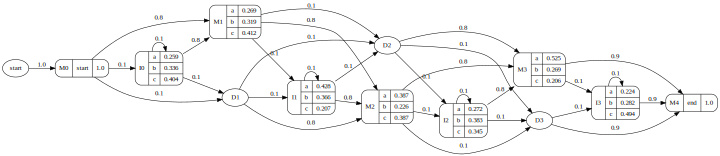

In [12]:
def initialize_phmm(num_states, symbols):
    """

    """
    states = []
    numsymbols = len(symbols)
    symbols.append('start')
    symbols.append('end')

    # states
    for i in range(0, num_states + 2):
        states.append('M' + str(i))
        states.append('D' + str(i))
        states.append('I' + str(i))

    # init
    init = {}
    for state in states:
        init[state] = 0.0
    init['M0'] = 1.0

    # tran
    exclude = ['D0', 'I' + str(num_states + 1), 'D' + str(num_states + 1)]
    tran = {}
    for state1 in states:
        i = state1[1:]
        tran[state1] = {}
        for state2 in states:
            j = state2[1:]
            if state1 in exclude or state2 in exclude:
                tran[state1][state2] = 0.0
            elif int(i) == int(j) - 1 and 'M' in state2:
                if int(i) == num_states:
                    tran[state1][state2] = 0.9
                else:
                    tran[state1][state2] = 0.8
            elif int(i) == int(j) and 'I' in state2:
                tran[state1][state2] = 0.1
            elif int(i) == int(j) - 1 and 'D' in state2:
                tran[state1][state2] = 0.1
            else:
                tran[state1][state2] = 0.0
    tran = pd.DataFrame(tran).transpose()

    # emis
    emis = {}
    for state in states:
        emis[state] = {}
        for symbol in symbols:
            if state == 'M0':
                if symbol == 'start':
                    emis[state][symbol] = 1.0
                else:
                    emis[state][symbol] = 0.0
            elif state == 'M' + str(num_states + 1):
                if symbol == 'end':
                    emis[state][symbol] = 1.0
                else:
                    emis[state][symbol] = 0.0
            elif state in exclude or 'D' in state:
                emis[state][symbol] = 0.0
            elif symbol != 'start' and symbol != 'end':
                emis[state][symbol] = (random.random() - 0.5) / 2 + 0.5
            else:
                emis[state][symbol] = 0.0
    emis = pd.DataFrame(emis).transpose()
    for row in states:
        total = sum(emis.loc[row, :])
        if total > 0:
            emis.loc[row, :] /= total

    priors = (init, tran, emis)

    return (priors, states)


def pHMMviz(priors, states, cluster=False):
    """
        Args:
            cluster: whether group M1/I1/D1 in a rectangle
    """
    g = graphviz.Digraph('G', engine='dot')
    g.attr(rankdir='LR', size='10, 10')
    init = priors[0]
    tran = priors[1]
    emis = priors[2]
    num_states = int(max([i[1:] for i in states if 'M' in i])) + 1
    for key in init:
        if init[key] > 0.00:
            g.edge('start', str(key), label=str(round(init[key], 3)), labeldistance='1')
    for row in tran.index:
        for col in tran.columns:
            if tran.loc[row, col] > 0.0:
                g.edge(str(row), str(col), label=str(round(tran.loc[row, col], 3)))
    for row in emis.index:
        strsymbol = ''
        stremis = ''
        for col in emis.columns:
            if emis.loc[row, col] > 0.0:
                if strsymbol != '':
                    strsymbol += '|'
                    stremis += '|'
                strsymbol += col
                stremis += str(round(emis.loc[row, col], 3))
        if str(row) == 'end':
            g.node(str(row))
        elif row == 'D0' or row == 'I' + str(num_states - 1) or row == 'D' + str(num_states - 1):
            continue
        elif 'D' in row:
            g.node(str(row), shape='oval')
        else:
            g.node(str(row), shape='Mrecord', label='{' + str(row) + '|{' + strsymbol + '}|{' + stremis + '}}')

    if cluster:
        for cnum in range(0,num_states-1):
            with g.subgraph(name='cluster'+str(cnum)) as c:
                c.node('M'+str(cnum))
                c.node('I'+str(cnum))
                if cnum>0:
                    c.node('D'+str(cnum))
    
    display(g)

symbols = get_symbols(corpus)
(priors, states) = initialize_phmm(3, symbols)

print("=== priors ===")
rich.print(priors[0])
display(priors[1])
display(priors[2])
print("=== state ===")
rich.print(states)
print("=== profileHMM ===")
pHMMviz(priors, states)

## Decoding

We use Viterbi for decoding.

*Reference: BSA 5.1*

In [13]:
def traceback(tbin):
    curi = len(tbin.columns) - 1
    current = 'M' + str(max([i[1] for i in tbin.index if 'M' in i]))
    tblist = []

    while current != 0:
        tblist.insert(0, current)
        #display('i am '+current+' at time i = '+str(curi))
        if current[0] != 'D':
            newi = curi - 1
        current = tbin.loc[current, curi]
        #display('i found '+str(current)+' at time i = '+str(newi))
        curi = newi
    return tblist


def max_dict(dictin):
    value = max(dictin.keys())
    name = dictin[value]
    return (name, value)


def viterbi(seqin, priors, states, symbols, show=False):
    init = priors[0]
    tran = priors[1]
    emis = priors[2]
    num_states = int(max([i[1:] for i in states if 'M' in i])) + 1
    seq = list(seqin)
    seq.insert(0, 'start')
    seq.append('end')
    vit = pd.DataFrame(0.0, index=states, columns=range(0, len(seq)))
    tb = pd.DataFrame(0.0, index=states, columns=range(0, len(seq)))
    vit.loc['M0', 0] = 1.0

    #display(seq)
    for i in range(0, len(seq)):
        for k in range(0, num_states):
            #M
            if k > 0 and i > 0:
                tbdict = {}
                eterm = emis.loc['M' + str(k), seq[i]]
                mterm = vit.loc['M' + str(k - 1), i - 1] * tran.loc['M' + str(k - 1), 'M' + str(k)]
                tbdict[mterm] = 'M' + str(k - 1)
                iterm = vit.loc['I' + str(k - 1), i - 1] * tran.loc['I' + str(k - 1), 'M' + str(k)]
                tbdict[iterm] = 'I' + str(k - 1)
                dterm = vit.loc['D' + str(k - 1), i - 1] * tran.loc['D' + str(k - 1), 'M' + str(k)]
                tbdict[dterm] = 'D' + str(k - 1)

                maxtuple = max_dict(tbdict)

                #if k==4 and i==2:
                #    display(tbdict)

                if maxtuple[1] > 0.0:
                    vit.loc['M' + str(k), i] = eterm * maxtuple[1]
                    tb.loc['M' + str(k), i] = maxtuple[0]
            #I
            if i > 0:
                tbdict = {}
                eterm = emis.loc['I' + str(k), seq[i]]
                mterm = vit.loc['M' + str(k), i - 1] * tran.loc['M' + str(k), 'I' + str(k)]
                tbdict[mterm] = 'M' + str(k)
                iterm = vit.loc['I' + str(k), i - 1] * tran.loc['I' + str(k), 'I' + str(k)]
                tbdict[iterm] = 'I' + str(k)
                dterm = vit.loc['D' + str(k), i - 1] * tran.loc['D' + str(k), 'I' + str(k)]
                tbdict[dterm] = 'D' + str(k)

                maxtuple = max_dict(tbdict)

                if maxtuple[1] > 0.0:
                    vit.loc['I' + str(k), i] = eterm * maxtuple[1]
                    tb.loc['I' + str(k), i] = maxtuple[0]
            #D
            if k > 0:
                tbdict = {}
                mterm = vit.loc['M' + str(k - 1), i] * tran.loc['M' + str(k - 1), 'D' + str(k)]
                tbdict[mterm] = 'M' + str(k - 1)
                iterm = vit.loc['I' + str(k - 1), i] * tran.loc['I' + str(k - 1), 'D' + str(k)]
                tbdict[iterm] = 'I' + str(k - 1)
                dterm = vit.loc['D' + str(k - 1), i] * tran.loc['D' + str(k - 1), 'D' + str(k)]
                tbdict[dterm] = 'D' + str(k - 1)

                #if k==3 and i==1:
                #    display(tbdict)

                maxtuple = max_dict(tbdict)
                if maxtuple[1] > 0.0:
                    vit.loc['D' + str(k), i] = maxtuple[1]
                    tb.loc['D' + str(k), i] = maxtuple[0]

    if show:
        display(vit)
        display(tb)
    return traceback(tb)


## Training

We use Baum-Welch (or forward-backward) for training.

In [38]:
def palpha(corpus, priors, states, symbols):
    init = priors[0]
    tran = priors[1]
    emis = priors[2]
    num_states = int(max([i[1:] for i in states if 'M' in i])) + 1
    for curseq in corpus:
        seq = list(curseq)
        seq.insert(0, 'start')
        seq.append('end')
        alpha = pd.DataFrame(0.0, index=states, columns=range(0, len(seq)))
        alpha.loc['M0', 0] = 1.0
        for i in range(0, len(seq)):
            for k in range(0, num_states):
                # M
                if k > 0 and i > 0:
                    eterm = emis.loc['M' + str(k), seq[i]]
                    mterm = alpha.loc['M' + str(k - 1), i - 1] * tran.loc['M' + str(k - 1), 'M' + str(k)]
                    iterm = alpha.loc['I' + str(k - 1), i - 1] * tran.loc['I' + str(k - 1), 'M' + str(k)]
                    dterm = alpha.loc['D' + str(k - 1), i - 1] * tran.loc['D' + str(k - 1), 'M' + str(k)]
                    alpha.loc['M' + str(k), i] = eterm * (mterm + iterm + dterm)
                # I
                if i > 0:
                    eterm = emis.loc['I' + str(k), seq[i]]
                    mterm = alpha.loc['M' + str(k), i - 1] * tran.loc['M' + str(k), 'I' + str(k)]
                    iterm = alpha.loc['I' + str(k), i - 1] * tran.loc['I' + str(k), 'I' + str(k)]
                    dterm = alpha.loc['D' + str(k), i - 1] * tran.loc['D' + str(k), 'I' + str(k)]
                    alpha.loc['I' + str(k), i] = eterm * (mterm + iterm + dterm)
                # D
                if k > 0:
                    mterm = alpha.loc['M' + str(k - 1), i] * tran.loc['M' + str(k - 1), 'D' + str(k)]
                    iterm = alpha.loc['I' + str(k - 1), i] * tran.loc['I' + str(k - 1), 'D' + str(k)]
                    dterm = alpha.loc['D' + str(k - 1), i] * tran.loc['D' + str(k - 1), 'D' + str(k)]
                    alpha.loc['D' + str(k), i] = (mterm + iterm + dterm)

        corpus[curseq]['alpha'] = alpha
        corpus[curseq]['prob'] = alpha.loc['M' + str(num_states - 1), len(seq) - 1]


def pbeta(corpus, priors, states, symbols):
    init = priors[0]
    tran = priors[1]
    emis = priors[2]
    num_states = int(max([i[1:] for i in states if 'M' in i])) + 1
    for curseq in corpus:
        seq = list(curseq)
        seq.insert(0, 'start')
        seq.append('end')
        beta = pd.DataFrame(0.0, index=states, columns=range(0, len(seq)))
        beta.loc['M' + str(num_states - 1), len(seq) - 1] = 1.0
        for i in range(len(seq) - 1, -1, -1):
            for k in range(num_states - 1, -1, -1):
                for state in ['M', 'D', 'I']:
                    #from M @ k+1
                    if k < num_states - 1 and i < len(seq) - 1:
                        bterm = beta.loc['M' + str(k + 1), i + 1]
                        tterm = tran.loc[state + str(k), 'M' + str(k + 1)]
                        eterm = emis.loc['M' + str(k + 1), seq[i + 1]]
                        beta.loc[state + str(k), i] += (bterm * tterm * eterm)
                    #from I @ k
                    if i < len(seq) - 1:
                        bterm = beta.loc['I' + str(k), i + 1]
                        tterm = tran.loc[state + str(k), 'I' + str(k)]
                        eterm = emis.loc['I' + str(k), seq[i + 1]]
                        beta.loc[state + str(k), i] += (bterm * tterm * eterm)
                    #from D @ k+1
                    if k < num_states - 1:
                        bterm = beta.loc['D' + str(k + 1), i]
                        tterm = tran.loc[state + str(k), 'D' + str(k + 1)]
                        eterm = emis.loc['D' + str(k + 1), seq[i]]
                        beta.loc[state + str(k), i] += (bterm * tterm * eterm)
        corpus[curseq]['beta'] = beta


def ploglike(corpus, priors, states, symbols):
    LL = 0
    palpha(corpus, priors, states, symbols)
    for seq in corpus:
        LL += corpus[seq]['count'] * np.log(corpus[seq]['prob'])
    return LL


palpha(corpus, priors, states, symbols)
pbeta(corpus, priors, states, symbols)
rich.print(corpus[('a','b','c')].keys())
print("=== alpha ===")
display(corpus[('a', 'b', 'c')]['alpha'])
print("=== beta ===")
display(corpus[('a', 'b', 'c')]['beta'])

dict_keys(['count', 'alpha', 'prob', 'beta'])

=== alpha ===


,0,1,2,3,4
M0,1.000000,0.000000,0.000000,0.000000e+00,0.000000
D0,0.000000,0.000000,0.000000,0.000000e+00,0.000000
I0,0.000000,0.016170,0.000097,6.296940e-06,0.000000
M1,0.000000,0.735464,0.000259,1.607657e-06,0.000000
D1,0.029767,0.001259,0.000008,4.903191e-07,0.000000
I1,0.000000,0.000120,0.010029,6.862372e-04,0.000000
M2,0.000000,0.000221,0.458494,1.450798e-04,0.000000
D2,0.015480,0.134534,0.000871,5.666965e-05,0.000000
I2,0.000000,0.000334,0.000285,6.611262e-03,0.000000
M3,0.000000,0.000257,0.022320,2.978603e-01,0.000000


=== beta ===


,0,1,2,3,4
M0,0.263509,0.000000,0.000000,0.000000,0.0
D0,0.000000,0.000000,0.000000,0.000000,0.0
I0,0.291000,0.000000,0.000000,0.000000,0.0
M1,0.006560,0.358290,0.000000,0.000000,0.0
D1,0.001962,0.238590,0.000000,0.000000,0.0
I1,0.003002,0.467725,0.000000,0.000000,0.0
M2,0.000768,0.010150,0.575506,0.000000,0.0
D2,0.000109,0.002660,0.681900,0.000000,0.0
I2,0.000324,0.005019,0.607783,0.000000,0.0
M3,0.000004,0.000055,0.008443,0.888448,0.0


In [40]:
def pnewemis(corpus, priors, states, symbols):
    init = priors[0]
    tran = priors[1]
    emis = priors[2]
    pseudocount = 1.0
    num_states = int(max([i[1:] for i in states if 'M' in i])) + 1
    newemis = pd.DataFrame(0.0, index=states, columns=symbols)
    # pseudocounts
    for state in states:
        for symbol in symbols:
            if (symbol != 'start') and (symbol != 'end') and \
                (state != 'M0') and (state != 'D0') and \
                (str(num_states - 1) not in state) and \
                ('D' not in state):
                newemis.loc[state, symbol] = pseudocount
    # populate
    for curseq in corpus:
        seq = list(curseq)
        seq.insert(0, 'start')
        seq.append('end')
        tempdf = corpus[curseq]['alpha'] * corpus[curseq]['beta']
        for i in range(0, len(seq)):
            cursymbol = seq[i]
            for state in states:
                if 'I' in state or 'M' in state:
                    newemis.loc[state, cursymbol] += tempdf.loc[state, i] / corpus[curseq]['prob'] * corpus[curseq]['count']
    return norm_by_row(newemis)


def pnewtran(corpus, priors, states, symbols):
    init = priors[0]
    tran = priors[1]
    emis = priors[2]
    num_states = int(max([i[1:] for i in states if 'M' in i])) + 1
    newtran = pd.DataFrame(0.0, index=states, columns=states)
    pseudocount = 1.0
    # pseudocount
    for k in range(0, num_states - 1):
        if k == 0:
            newtran.loc['M' + str(k), 'M' + str(k + 1)] = 1.0
            newtran.loc['M' + str(k), 'I' + str(k)] = 1.0
            newtran.loc['M' + str(k), 'D' + str(k + 1)] = 1.0
            newtran.loc['I' + str(k), 'M' + str(k + 1)] = 1.0
            newtran.loc['I' + str(k), 'I' + str(k)] = 1.0
            newtran.loc['I' + str(k), 'D' + str(k + 1)] = 1.0
        elif k == num_states - 2:
            for state in ['M', 'I', 'D']:
                newtran.loc[state + str(k), 'M' + str(k + 1)] = 1.0
                newtran.loc[state + str(k), 'I' + str(k)] = 1.0
        else:
            for state in ['M', 'I', 'D']:
                newtran.loc[state + str(k), 'M' + str(k + 1)] = 1.0
                newtran.loc[state + str(k), 'I' + str(k)] = 1.0
                newtran.loc[state + str(k), 'D' + str(k + 1)] = 1.0
    # newtran.loc['I'+str(num_states-2),'I'+str(num_states-2)]=1.0

    for curseq in corpus:
        seq = list(curseq)
        seq.insert(0, 'start')
        seq.append('end')
        for k in range(0, num_states):
            for state in ['M', 'I', 'D']:
                for i in range(0, len(seq)):
                    #to M @ k+1
                    if i < len(seq) - 1 and k < num_states - 1:
                        aterm = corpus[curseq]['alpha'].loc[state + str(k), i]
                        tterm = tran.loc[state + str(k), 'M' + str(k + 1)]
                        eterm = emis.loc['M' + str(k + 1), seq[i + 1]]
                        bterm = corpus[curseq]['beta'].loc['M' + str(k + 1), i + 1]
                        newtran.loc[state + str(k), 'M' + str(k + 1)] += (aterm * bterm * eterm * tterm) / corpus[curseq]['prob'] * corpus[curseq]['count']

                    #to I @ k
                    if i < len(seq) - 1:
                        aterm = corpus[curseq]['alpha'].loc[state + str(k), i]
                        tterm = tran.loc[state + str(k), 'I' + str(k)]
                        eterm = emis.loc['I' + str(k), seq[i + 1]]
                        bterm = corpus[curseq]['beta'].loc['I' + str(k), i + 1]
                        newtran.loc[state + str(k), 'I' + str(k)] += (aterm * bterm * eterm * tterm) / corpus[curseq]['prob'] * corpus[curseq]['count']

                    #to D @ k+1
                    if k < num_states - 1:
                        aterm = corpus[curseq]['alpha'].loc[state + str(k), i]
                        tterm = tran.loc[state + str(k), 'D' + str(k + 1)]
                        bterm = corpus[curseq]['beta'].loc['D' + str(k + 1), i]
                        newtran.loc[state + str(k), 'D' + str(k + 1)] += (aterm * bterm * eterm * tterm) / corpus[curseq]['prob'] * corpus[curseq]['count']

    return norm_by_row(newtran)


palpha(corpus, priors, states, symbols)
pbeta(corpus, priors, states, symbols)
pnewemis(corpus, priors, states, symbols)

,a,b,c,start,end
M0,0.000000,0.000000,0.000000,1.0,0.0
D0,0.000000,0.000000,0.000000,0.0,0.0
I0,0.333333,0.333333,0.333333,0.0,0.0
M1,0.980452,0.009774,0.009774,0.0,0.0
D1,0.000000,0.000000,0.000000,0.0,0.0
I1,0.338002,0.330999,0.330999,0.0,0.0
M2,0.009868,0.980372,0.009760,0.0,0.0
D2,0.000000,0.000000,0.000000,0.0,0.0
I2,0.329910,0.345643,0.324447,0.0,0.0
M3,0.009084,0.076515,0.914401,0.0,0.0


## Example: A Trivial Case

The main pattern is a->b->c, there are two ways to get a profileHMM:
- direct set the prior without training
- train the model with Baum-Welch

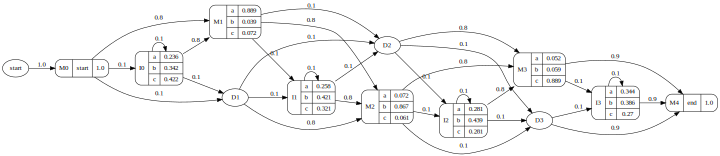

a b c :  M0 -> M1 -> M2 -> M3 -> M4
c :  M0 -> D1 -> D2 -> M3 -> M4


In [41]:
# yapf: disable
corpus={
    ('a','b','c'):{'count':100},
    ('c'):{'count':10},
}
# yapf: enable
symbols = get_symbols(corpus)
(priors, states) = initialize_phmm(3, symbols)

# heuristically set a good prior
priors[2].loc['M1', 'a'] = 5.0
priors[2].loc['M2', 'b'] = 5.0
priors[2].loc['M3', 'c'] = 5.0
norm_by_row(priors[2])

# train with baum-welch
# for i in range(0, 20):
#     palpha(corpus, priors, states, symbols)
#     pbeta(corpus, priors, states, symbols)
#     newemis = pnewemis(corpus, priors, states, symbols)
#     newtran = pnewtran(corpus, priors, states, symbols)
#     priors = (priors[0], newtran, newemis)

pHMMviz(priors, states)
for seq in corpus:
    print(" ".join(seq), ": ", " -> ".join(viterbi(seq, priors, states, symbols, show=False)))



## Example: More Complex Case


step-0, loss= -484.0688287195932
step-1, loss= -447.5763617507561
step-2, loss= -434.36539229437506
step-3, loss= -425.4258231446828
step-4, loss= -415.56490768409185
step-5, loss= -410.995536303347
step-6, loss= -409.8641252232929
step-7, loss= -409.61763668398567
step-8, loss= -409.5337244637496
step-9, loss= -409.4995216847868


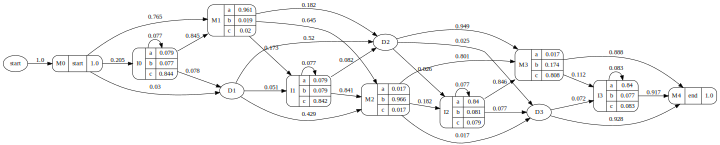

a b c :  M0 -> M1 -> M2 -> M3 -> M4
a :  M0 -> M1 -> D2 -> D3 -> M4
b :  M0 -> D1 -> D2 -> M3 -> M4
c :  M0 -> D1 -> D2 -> M3 -> M4
a b :  M0 -> M1 -> D2 -> M3 -> M4
b c :  M0 -> D1 -> M2 -> M3 -> M4
a c :  M0 -> M1 -> D2 -> M3 -> M4
c a b c :  M0 -> I0 -> M1 -> M2 -> M3 -> M4
a c b c :  M0 -> M1 -> I1 -> M2 -> M3 -> M4
a b a c :  M0 -> M1 -> M2 -> I2 -> M3 -> M4
a b c a :  M0 -> M1 -> M2 -> M3 -> I3 -> M4


In [42]:
# yapf: disable
corpus={
    ('a','b','c'): {'count': 10},
    ('a'): {'count': 10},
    ('b'): {'count': 10},
    ('c'): {'count': 10},
    ('a','b'): {'count': 10},
    ('b','c'): {'count': 10},
    ('a','c'): {'count': 10},
    ('c','a','b','c'): {'count': 10},
    ('a','c','b','c'): {'count': 10},
    ('a','b','a','c'): {'count': 10},
    ('a','b','c','a'): {'count': 10},
}
# yapf: enable
symbols = get_symbols(corpus)
(priors, states) = initialize_phmm(3, symbols)
#pHMMviz(priors,states)
for i in range(0, 10):
    palpha(corpus, priors, states, symbols)
    pbeta(corpus, priors, states, symbols)
    newemis = pnewemis(corpus, priors, states, symbols)
    newtran = pnewtran(corpus, priors, states, symbols)
    priors = (priors[0], newtran, newemis)
    print(f"step-{i}, loss=", ploglike(corpus, priors, states, symbols))
pHMMviz(priors, states)
for seq in corpus:
    print(" ".join(seq), ": ", " -> ".join(viterbi(seq, priors, states, symbols, show=False)))
